## Database

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

from skimage.measure import regionprops, label, find_contours
from skimage.filters import threshold_otsu
from skimage.morphology import disk, erosion, dilation, closing

from skimage import img_as_ubyte

In [2]:
# Read inputs
root = 'C:/Users/nilso/Documents/EPFL/MA4/PDS Turberg/'
folder = '/Cuttings_data/'
test_name = '/MS-DB-Geo01-1/'

dirname = os.path.dirname(root)
file_path = os.path.dirname(dirname+folder) 

#ML-DB-Geo1
train_tiffs = os.listdir(file_path+test_name)

# Save figures 
save_folder = 'Rock_Cuttings_Characterisation/Data/'
save_subfolder = 'dev/'
save_path = root + save_folder + save_subfolder

In [3]:
# Load one example
tiff = train_tiffs[495]
image = cv2.imread(file_path + test_name + tiff, cv2.IMREAD_GRAYSCALE)

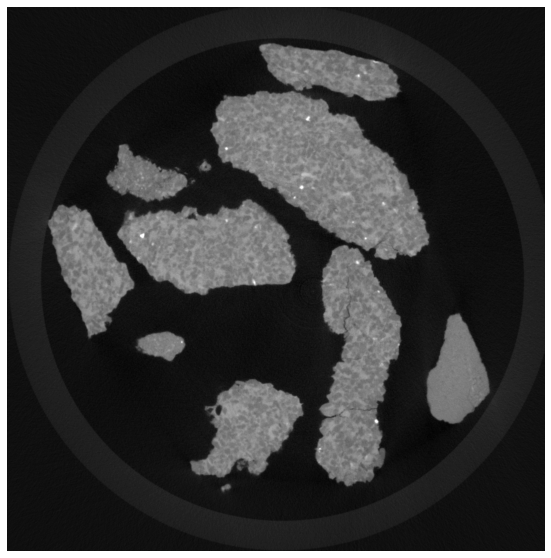

In [4]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(image, cmap='gray')
plt.axis('off')
plt.savefig(save_path+'algo_1.png',bbox_inches='tight')

In [5]:
def assign_mask(image):
    mask = image > threshold_otsu(image)
    return mask

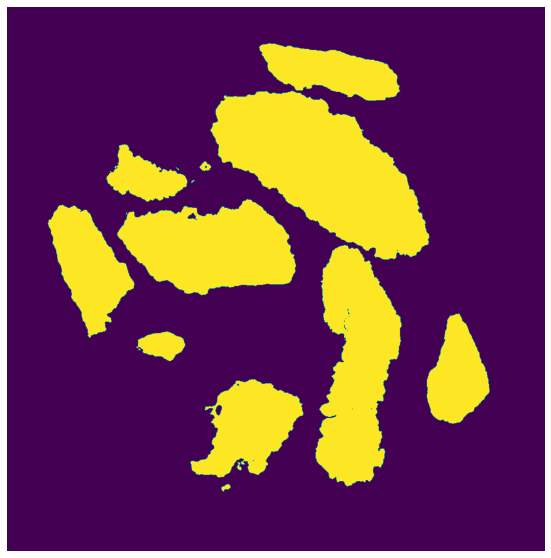

In [6]:
fig,ax = plt.subplots(figsize=(10,10))
mask = assign_mask(image)
ax.imshow(mask)
plt.axis(False)
plt.axis('off')
plt.savefig(save_path+'algo_2.png',bbox_inches='tight')

In [7]:
selem = disk(3)

eroded = mask.copy()

for i in range(0,3):
    eroded = erosion(eroded, selem)

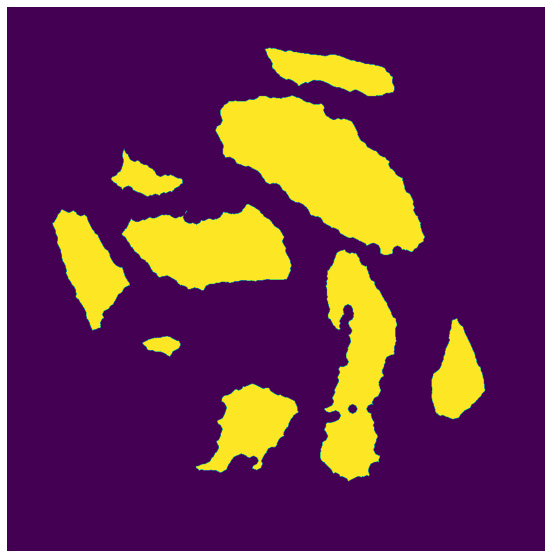

In [8]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(eroded) 
plt.axis('off')
plt.savefig(save_path+'algo_3.png',bbox_inches='tight')

In [9]:
dilated = label(eroded).copy()

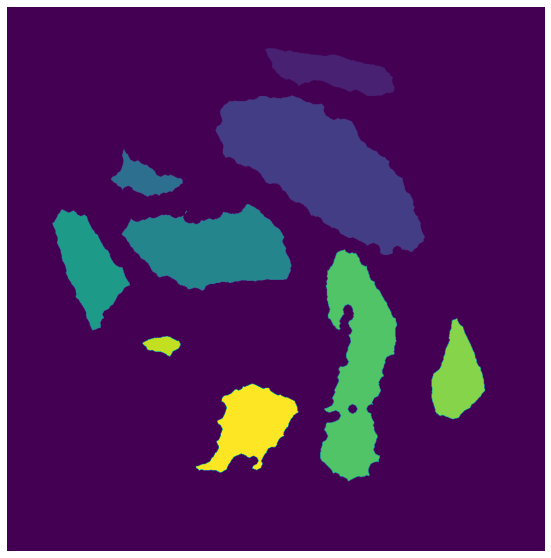

In [10]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(dilated) 
plt.axis('off')
plt.savefig(save_path+'algo_4.png',bbox_inches='tight')

In [11]:
for i in range(0,3):
    dilated = dilation(dilated, selem)
for i in range(0,3):    
    dilated = closing(dilated, disk(1))

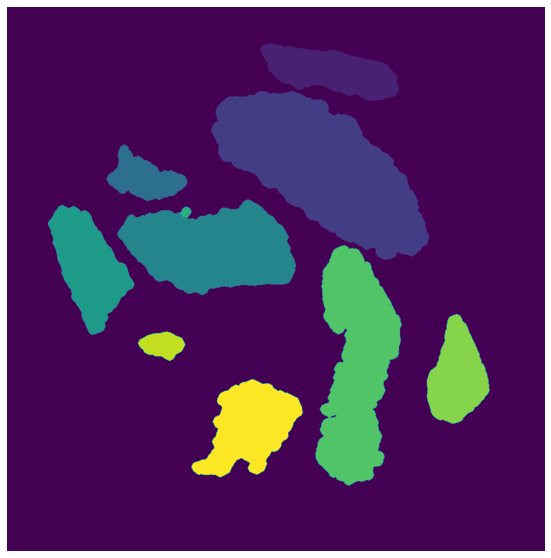

In [12]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(dilated) 
plt.axis('off')
plt.savefig(save_path+'algo_5.png',bbox_inches='tight')

#### Test big samples

In [13]:
def big_cuttings(dilated,threshold=1000):
    """
    take as input an image with labels, return the fragments greater than 1000px 
    """
    big_samples = []
    for i in range(len(regionprops(dilated))):
        if regionprops(dilated)[i].area > threshold : big_samples.append(i)
    return big_samples

In [14]:
big_samples = big_cuttings(dilated)

In [15]:
len(big_samples)

9

In [16]:
def plot_samples(image,label_image,im):
    minr, minc, maxr, maxc = regionprops(label_image)[im].bbox
        
    fig,ax = plt.subplots(1,2)
        
    ax[0].imshow(image[minr:maxr,minc:maxc]*regionprops(label_image)[im].image,
                cmap=plt.cm.gray,aspect="auto")
    ax[0].axis(False)
    ax[1].imshow(regionprops(label_image)[im].image,
                cmap=plt.cm.gray,aspect="auto")
    ax[1].axis(False)
    plt.show()

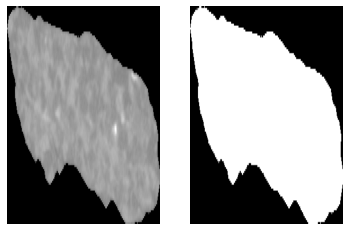

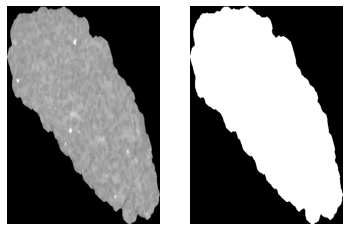

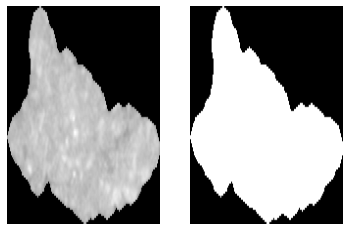

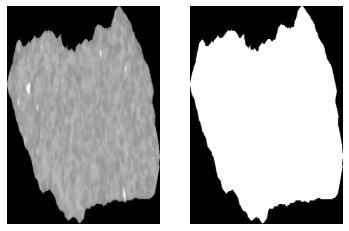

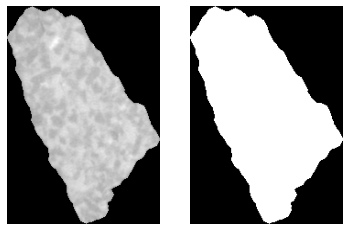

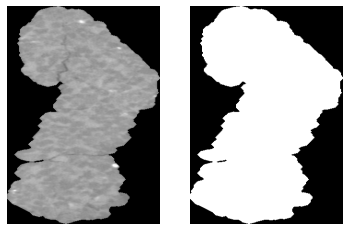

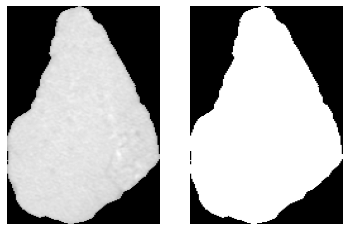

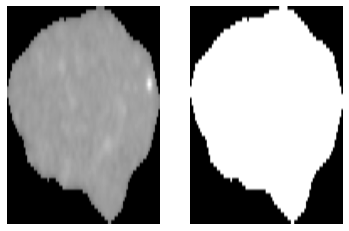

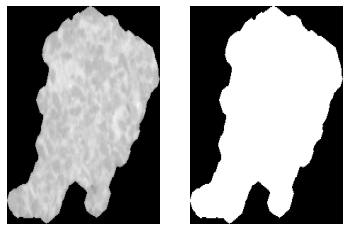

In [18]:
for im in big_samples:
    plot_samples(image,dilated,im)

In [19]:
def plot_samples_resized(image,label_image,im,WIDTH=128,HEIGHT=128): 
    minr, minc, maxr, maxc = regionprops(label_image)[im].bbox
        
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(cv2.resize(image[minr:maxr,minc:maxc]*regionprops(label_image)[im].image,
                   (WIDTH,HEIGHT), 
                   interpolation=cv2.INTER_CUBIC),
                cmap='gray')
    ax[0].axis(False)
    ax[1].imshow(cv2.resize(regionprops(label_image)[im].image.astype(np.uint8),
                   (WIDTH,HEIGHT), 
                   interpolation=cv2.INTER_CUBIC),
                cmap='gray')
    ax[1].axis(False)
    plt.tight_layout()
    plt.show()

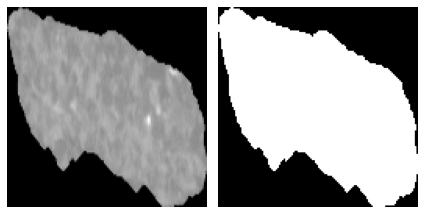

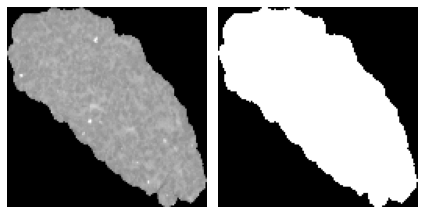

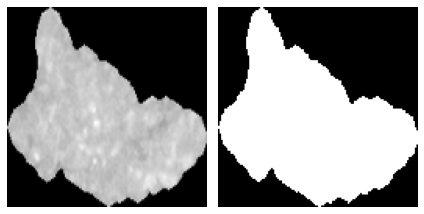

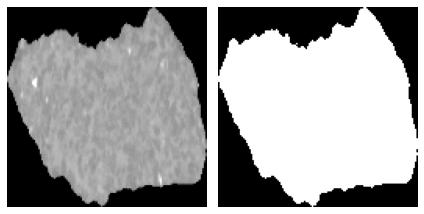

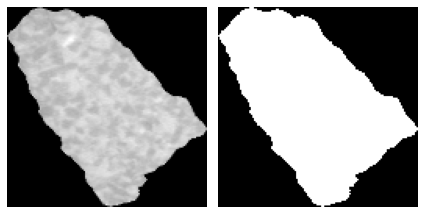

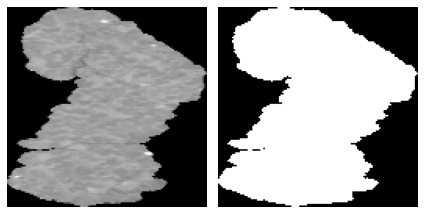

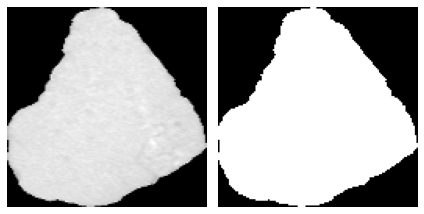

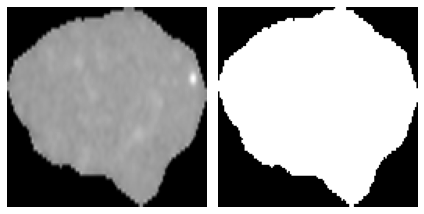

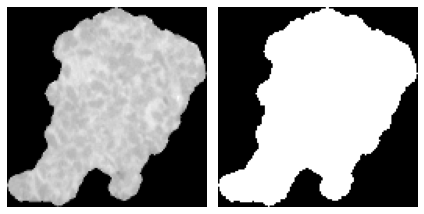

In [20]:
for im in big_samples:
    plot_samples_resized(image,dilated,im)

#### Crop Rectangle function

In [21]:
def crop_rectangle(im_rect,box,rect):
    W = rect[1][0]
    H = rect[1][1]
    
    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)
    
    rotated = False
    angle = rect[2]
    
    if angle < -45:
        angle+=90
        rotated = True

    if angle > 45:
        angle-=90
        rotated = True
        
    size = (x2-x1,y2-y1)
    center = (int((x1+x2)/2), int((y1+y2)/2))
    
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)
    
    cropped = cv2.getRectSubPix(im_rect, size, center)    
    cropped = cv2.warpAffine(cropped, M, size)
    
    croppedW = W if not rotated else H 
    croppedH = H if not rotated else W
    
    croppedRotated = cv2.getRectSubPix(cropped, (int(croppedW), int(croppedH)), (size[0]/2, size[1]/2))
    return croppedRotated

In [22]:
def pad_image(im_rect_not_pad,desired_size=128):
    old_size = im_rect_not_pad.shape[:2]
    
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im_rect_not_pad = cv2.resize(im_rect_not_pad, (new_size[1], new_size[0]),interpolation=cv2.INTER_CUBIC)
    
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    
    color = 0
    
    im_rect_pad = cv2.copyMakeBorder(im_rect_not_pad, top, bottom, left, right, cv2.BORDER_CONSTANT,
    value=color)
    return im_rect_pad

In [23]:
def plot_rectangular_samples_resized(image,dilated,im,WIDTH = 128,HEIGHT = 128):
    im_rect = img_as_ubyte(dilated == regionprops(dilated)[im].label)#.astype(np.uint8)
    contours,_ = cv2.findContours(im_rect, 1, 2)
    rect = cv2.minAreaRect(contours[0])
    if len(contours) >= 2:
        cmax = sorted(contours, key=cv2.contourArea, reverse=True)[0]
        rect = cv2.minAreaRect(cmax)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
        
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(cv2.resize(crop_rectangle(im_rect,box,rect),
                   (WIDTH,HEIGHT), 
                   interpolation=cv2.INTER_CUBIC),
                cmap='gray')
    ax[0].axis(False)
    ax[1].imshow(cv2.resize(crop_rectangle(image*im_rect,box,rect),
                   (WIDTH,HEIGHT), 
                   interpolation=cv2.INTER_CUBIC),
                cmap='gray')
    ax[1].axis(False)
    plt.show()

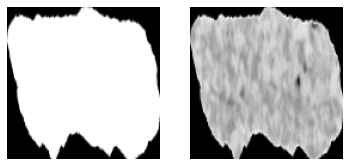

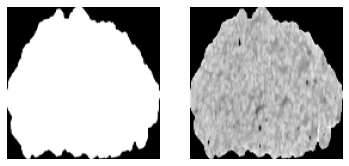

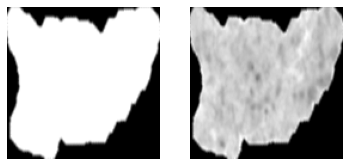

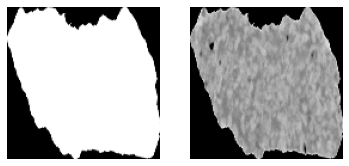

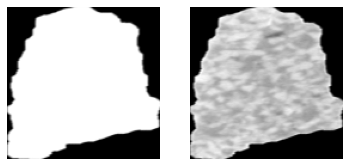

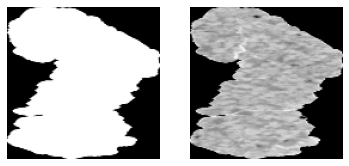

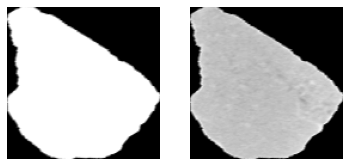

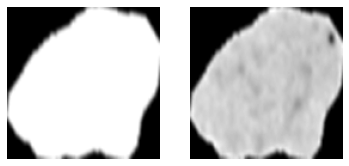

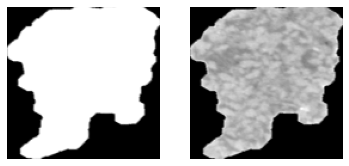

In [24]:
for im in big_samples :
    plot_rectangular_samples_resized(image,dilated,im)

#### Figure with Bbox

(-0.5, 1038.5, 1050.5, -0.5)

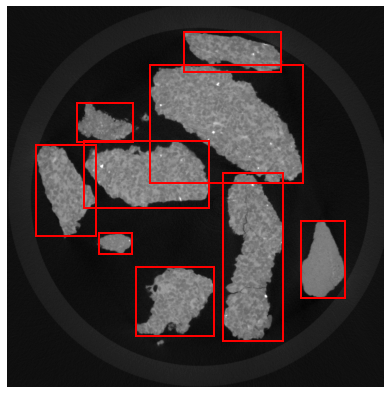

In [25]:
rect_image = image.copy()
fig,ax = plt.subplots(figsize=(7,7))
for im in big_samples :
    # draw bbox
    minr, minc, maxr, maxc = regionprops(dilated)[im].bbox
    rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
    
    ax.add_patch(rect)
ax.imshow(image,cmap='gray')
plt.axis(False)

#### Figure with rectangle

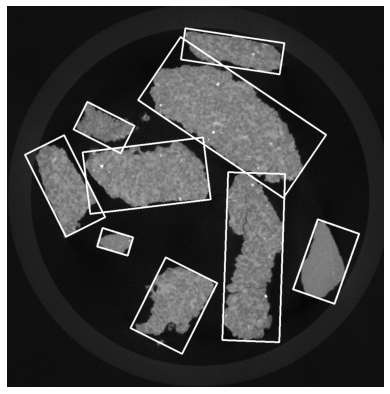

In [27]:
rect_image = image.copy()
fig,ax = plt.subplots(figsize=(7,7))
for im in big_samples :
    im_rect = (dilated == regionprops(dilated)[im].label).astype(np.uint8)
    
    contours,_ = cv2.findContours(im_rect, 1, 2)
    rect = cv2.minAreaRect(contours[0])
    if len(contours) >= 2:
        cmax = sorted(contours, key=cv2.contourArea, reverse=True)[0]
        rect = cv2.minAreaRect(cmax) 
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    im = cv2.drawContours(rect_image,[box],0,(255,0,0),4)
ax.imshow(im,cmap='gray')
plt.axis(False)
plt.savefig('experimental_set_up.png',bbox_inches='tight',dpi=600)

#### Figure with rectangle and bbox

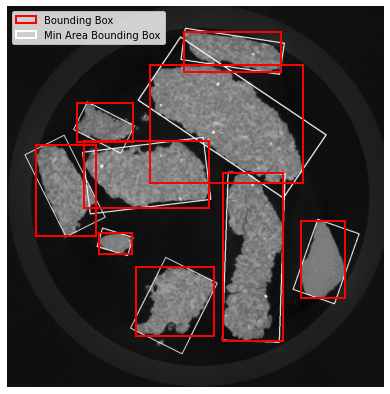

In [326]:
rect_image = image.copy()
fig,ax = plt.subplots(figsize=(7,7))
for im in big_samples :
    # draw rectangle
    im_rect = (dilated == regionprops(dilated)[im].label).astype(np.uint8)
    
    contours,_ = cv2.findContours(im_rect, 1, 2)
    rect = cv2.minAreaRect(contours[0])
    if len(contours) >= 2:
        cmax = sorted(contours, key=cv2.contourArea, reverse=True)[0]
        rect = cv2.minAreaRect(cmax) 
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    #box_array.append(box) 
    
    # draw bbox
    minr, minc, maxr, maxc = regionprops(dilated)[im].bbox
    rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
    
    ax.add_patch(rect)
    im = cv2.drawContours(rect_image,[box],0,(255,0,0),thickness=2)
ax.imshow(im,cmap='gray')
plt.axis(False)
leg = plt.gca().legend(('Bounding Box','Min Area Bounding Box'))
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('white')

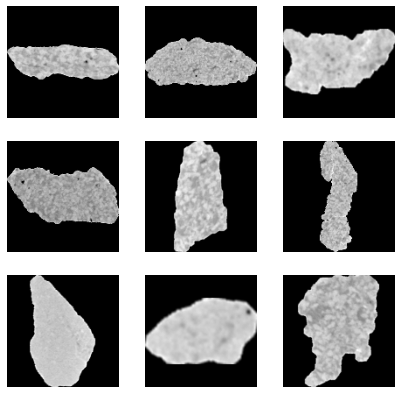

In [327]:
fig, axs = plt.subplots(3,3,figsize=(7,7))

axs = axs.ravel()

for i,im in enumerate(big_samples):
    im_rect = img_as_ubyte(dilated == regionprops(dilated)[im].label)#.astype(np.uint8)
    contours,_ = cv2.findContours(im_rect, 1, 2)
    rect = cv2.minAreaRect(contours[0])
    if len(contours) >= 2:
        cmax = sorted(contours, key=cv2.contourArea, reverse=True)[0]
        rect = cv2.minAreaRect(cmax)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    axs[i].imshow(pad_image(crop_rectangle(image*im_rect,box,rect)),
                cmap='gray')
    axs[i].axis(False)
plt.savefig('experimental_set_up_padded.png',bbox_inches='tight',dpi=600)

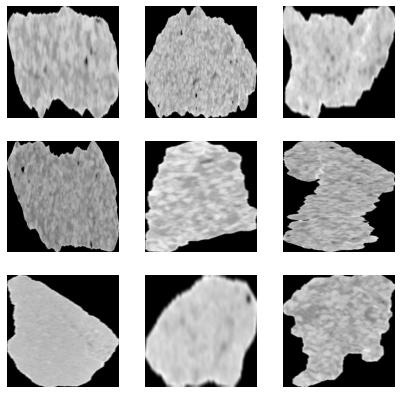

In [328]:
fig, axs = plt.subplots(3,3,figsize=(7,7))

axs = axs.ravel()

for i,im in enumerate(big_samples):
    im_rect = img_as_ubyte(dilated == regionprops(dilated)[im].label)#.astype(np.uint8)
    contours,_ = cv2.findContours(im_rect, 1, 2)
    rect = cv2.minAreaRect(contours[0])
    if len(contours) >= 2:
        cmax = sorted(contours, key=cv2.contourArea, reverse=True)[0]
        rect = cv2.minAreaRect(cmax)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    WIDTH = 224
    HEIGHT = 224
    axs[i].imshow(cv2.resize(crop_rectangle(image*im_rect,box,rect),
                   (WIDTH,HEIGHT), 
                   interpolation=cv2.INTER_CUBIC),
                cmap='gray')
    axs[i].axis(False)
plt.savefig('experimental_set_up_not_padded.png',bbox_inches='tight',dpi=600)  

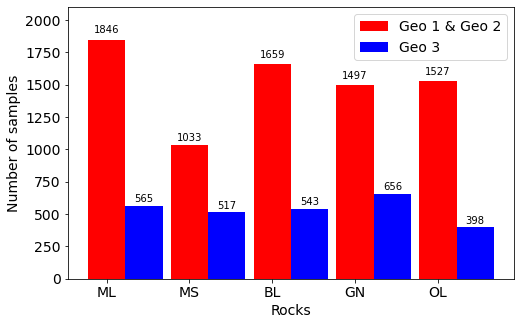

In [329]:
# Train Test Split
labels = ['ML','MS','BL','GN','OL']

train = [1846,1033,1659,1497,1527]
test = [565,517,543,656,398]

ind = np.arange(len(labels))

bar_width = 0.45

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(ind, train, bar_width, color='r',
                label='Geo 1 & Geo 2')
rects2 = ax.bar(ind+bar_width, test, bar_width, color='b',
                label='Geo 3')
ax.set_xlabel('Rocks',fontsize=14)
ax.set_ylabel('Number of samples',fontsize=14)
ax.set_xticks(ind)
ax.set_xticklabels(labels,fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.ylim(0,2100)
for rect, tr in zip(rects1, train):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height*1.02, '{}'.format(tr), ha='center', va='bottom')
for rect, te in zip(rects2, test):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height*1.02, '{}'.format(te), ha='center', va='bottom')

plt.savefig('train_test_validation.png',dpi=600,bbox_inches='tight')